In [1]:
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import os
import string

print(os.listdir("./dataset/"))

['sample_submission.csv', 'survey_questions.csv', 'test.csv', 'train.csv']


In [2]:
import warnings
warnings.filterwarnings('ignore')

from nltk.tokenize import sent_tokenize, word_tokenize, WhitespaceTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from wordcloud import WordCloud

# add sentiment anaylsis columns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# create doc2vec vector columns
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [3]:
df_train = pd.read_csv('./dataset/train.csv')
df_test = pd.read_csv('./dataset/test.csv')
df_sample = pd.read_csv('./dataset/sample_submission.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30336 entries, 0 to 30335
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   ID              30336 non-null  int64  
 1   Place           30336 non-null  object 
 2   location        19082 non-null  object 
 3   date            30336 non-null  object 
 4   status          30336 non-null  object 
 5   job_title       30336 non-null  object 
 6   summary         30284 non-null  object 
 7   positives       30336 non-null  object 
 8   negatives       30336 non-null  object 
 9   advice_to_mgmt  17059 non-null  object 
 10  score_1         27150 non-null  float64
 11  score_2         24286 non-null  float64
 12  score_3         27167 non-null  float64
 13  score_4         27145 non-null  float64
 14  score_5         26851 non-null  float64
 15  score_6         30336 non-null  int64  
 16  overall         30336 non-null  float64
dtypes: float64(6), int64(2), object

In [5]:
df_train.sample(5)

,ID,Place,location,date,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall
19705,44238,startup_2,"Houston, TX","Jul 11, 2014",Current Employee,Anonymous Employee,"Great expierence, but had to move on","Good Pay, Great co-workers, fun atmosphere",can get mundane management isnt always the best,Just go all out for your people.,4.0,5.0,4.0,4.0,4.0,1,5.0
5982,13529,startup_4,"Jacksonville, FL","Oct 13, 2017",Current Employee,OMR,OMR on-site medical rep - EMT-p,It is such an amazing place to work ! I have b...,I have no cons to list !!,Keep up the great work !!!!,5.0,5.0,5.0,5.0,5.0,0,4.0
11832,26663,startup_4,Bengaluru (India),"Aug 5, 2018",Current Employee,Senior Associate,Crazy work place to be,Everyone follow the key leadership principles.,Lot of competition to get promoted to the next...,Do not change the Amazon Culture.,5.0,5.0,4.0,4.0,4.0,0,4.0
12268,27624,startup_4,NaN,"Apr 19, 2018",Former Employee,Anonymous Employee,amazon logistics SDS,Work environment definitely makes it worth eve...,Sometimes there are changes made without the r...,When changes are being made it would be helpfu...,5.0,5.0,5.0,5.0,5.0,1,5.0
6779,15357,startup_4,"Lexington-Fayette, KY","Jun 16, 2017",Current Employee,Level III,amazing,best place to work at amazon,i couldnt find anything to say,NaN,5.0,5.0,5.0,5.0,5.0,0,5.0


In [6]:
df_train.shape, df_test.shape

((30336, 17), (29272, 16))

In [7]:
df_train.isnull().sum()

ID                    0
Place                 0
location          11254
date                  0
status                0
job_title             0
summary              52
positives             0
negatives             0
advice_to_mgmt    13277
score_1            3186
score_2            6050
score_3            3169
score_4            3191
score_5            3485
score_6               0
overall               0
dtype: int64

In [8]:
col = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']
for c in col:
    df_train[c].fillna(df_train[c].dropna().median(), inplace=True)
    df_test[c].fillna(df_train[c].dropna().median(), inplace=True)

col1 = ['negatives', 'summary', 'advice_to_mgmt']
for c in col1:
    df_train[c].fillna('', inplace=True)
    df_test[c].fillna('', inplace=True)

In [9]:
drop_col = ['ID', 'location', 'date']
df_train.drop(columns=drop_col, inplace=True)
df_test.drop(columns=drop_col, inplace=True)

In [10]:
df_train.shape, df_test.shape

((30336, 14), (29272, 13))

In [11]:
df_train['Place'].value_counts()

startup_4    11758
startup_6     8172
startup_2     5863
startup_1     3468
startup_5      698
startup_3      377
Name: Place, dtype: int64

In [12]:
df_train['status'].value_counts()

Current Employee     19087
Former Employee      11249
Name: status, dtype: int64

In [13]:
df_train['overall'].value_counts()

4.0    10688
3.0     9510
5.0     5975
2.0     3531
1.0      632
Name: overall, dtype: int64

In [14]:
LEncoder  = LabelEncoder()
df_train['Place'] = LEncoder.fit_transform(df_train['Place'])
df_train['status'] = LEncoder.fit_transform(df_train['status'])

df_test['Place'] = LEncoder.fit_transform(df_test['Place'])
df_test['status'] = LEncoder.fit_transform(df_test['status'])

In [15]:
df_train.isnull().sum().any(), df_test.isnull().sum().any()

(False, False)

In [16]:
df_train.sample(5)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall
19011,1,0,Apple Genius,not a bad place to work,"great benefits, good people, decent pay",not a lot of opportunity to grow within the co...,,2.0,4.0,3.0,5.0,3.0,0,3.0
13212,3,0,Associate Partner Manager,Great salary and training for junior staff,Interesting & challenging role Above average s...,More work than you can manage - sometimes you ...,Keep spending time with junior members of staf...,3.0,4.0,4.0,5.0,3.0,1,3.0
9817,3,0,Software Development Engineer I,Enjoyable except for on-call,"Competitive pay, especially with stocks. Surr...","On-call rotation sucks, there's no two-ways ar...",Continue to respect employee's work-life balan...,4.0,3.0,5.0,4.0,4.0,7,3.0
23510,5,0,Program Manager II,Opportunities Galore,"Challenging, super smart colleagues, cutting e...","Can be a political atmosphere, inconsistent tr...",,4.0,4.0,5.0,4.0,4.0,0,3.0
20721,1,0,QA Engineer,"Some flaws, but in general a fantastic place t...",Coworkers are very high quality,"Management are just people good at their job, ...",Promote better managers rather than good perfo...,4.0,4.0,1.0,3.0,3.0,4,4.0


# Positive and Negative

In [17]:
def Review_len(df):
    df['len_pos'] = df['positives'].str.len()
    df['len_neg'] = df['negatives'].str.len()

Review_len(df_train)
Review_len(df_test)

In [18]:
def ChangeToInt(df, col):
    df[col]=df[col].astype('int')

label='overall'
ChangeToInt(df_train, label)

In [19]:
df_train.head()

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall,len_pos,len_neg
0,0,0,Anonymous Employee,Best Company to work for,People are smart and friendly,Bureaucracy is slowing things down,,4.0,5.0,5.0,4.0,5.0,0,5,29,34
1,0,1,Program Manager,"Moving at the speed of light, burn out is inev...","1) Food, food, food. 15+ cafes on main campus ...",1) Work/life balance. What balance? All those ...,1) Don't dismiss emotional intelligence and ad...,2.0,3.0,3.0,5.0,3.0,2094,5,1048,2403
2,0,0,Software Engineer III,Great balance between big-company security and...,"* If you're a software engineer, you're among ...","* It *is* becoming larger, and with it comes g...",Keep the focus on the user. Everything else wi...,5.0,4.0,5.0,5.0,4.0,949,5,3634,1064
3,0,0,Anonymous Employee,The best place I've worked and also the most d...,You can't find a more well-regarded company th...,I live in SF so the commute can take between 1...,Keep on NOT micromanaging - that is a huge ben...,2.0,5.0,5.0,4.0,5.0,498,4,1572,2614
4,0,0,Anonymous Employee,Execellent for engineers,Impact driven. Best tech in the world.,Size matters. Engineers are a bit disconnected...,,5.0,5.0,5.0,5.0,5.0,0,4,38,62


In [20]:
def show_wordcloud(data, title = None):
    V_wordcloud = WordCloud(background_color = 'white', max_words = 200, max_font_size = 40, scale = 3, random_state = 7).generate(str(data))
    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(V_wordcloud)
    plt.show()

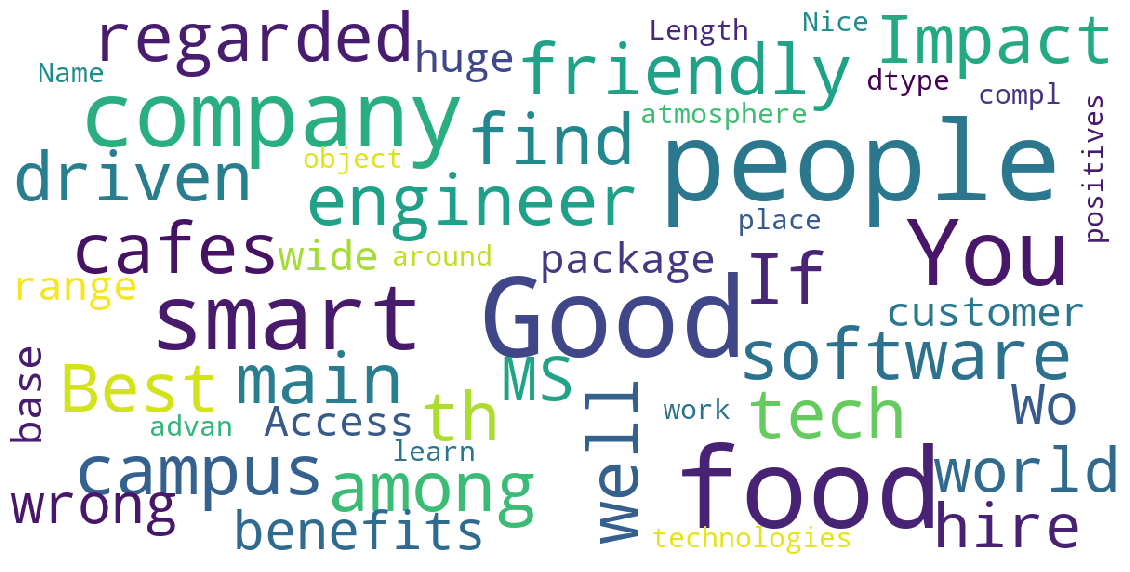

In [21]:
# print positive wordcloud
show_wordcloud(df_train["positives"])

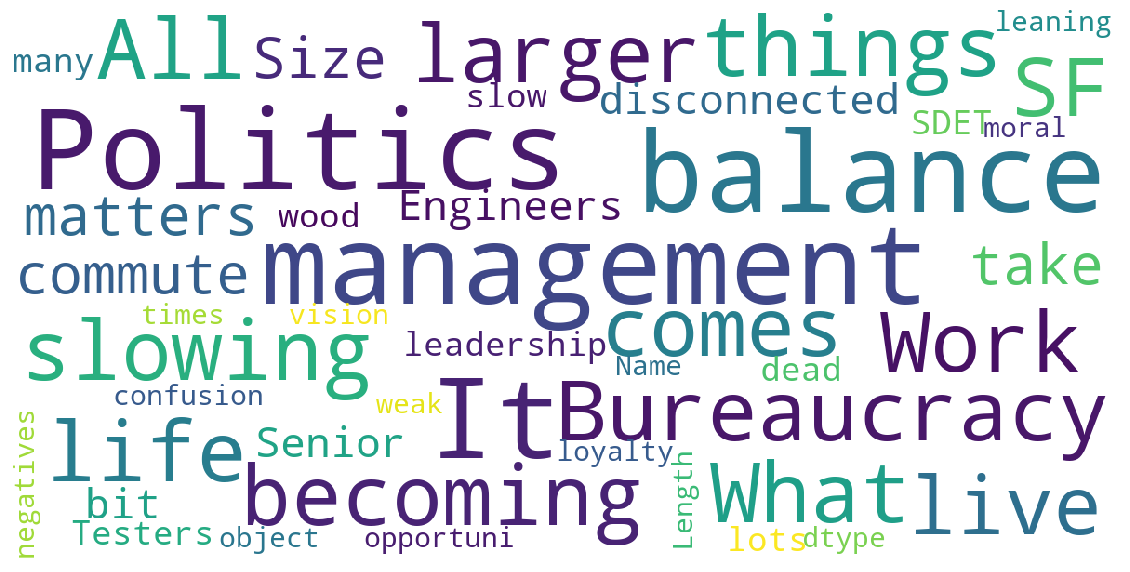

In [22]:
# print negatives wordcloud
show_wordcloud(df_train["negatives"])

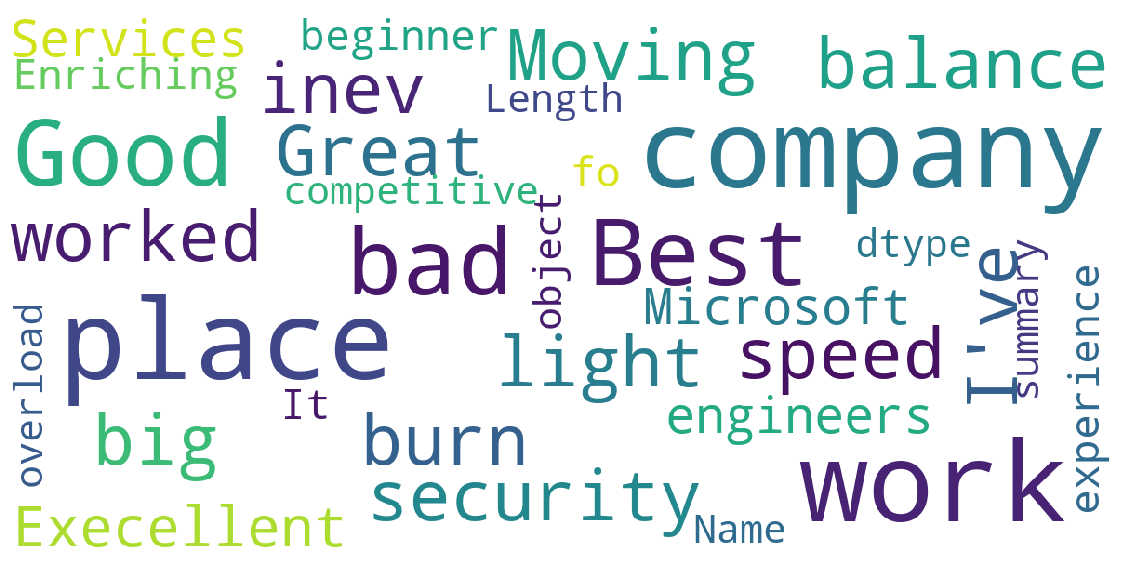

In [23]:
# print summary wordcloud
show_wordcloud(df_train["summary"])

In [24]:
# Get the lemmas of words from wordnet corpus reader
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [25]:
def clean_text(text):
    # lower text
    text = text.lower()
    
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    
    # remove empty and less than 3 length tokens
    text = [t for t in text if len(t) >= 3]
    
    # pos tag text
    pos_tags = pos_tag(text)
    
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    
    # remove words with less than 3 letters
    text = [t for t in text if len(t) >= 3]
    
    # join all
    text = " ".join(text)
    return(text)

In [26]:
df_train["Clean_positives"] = df_train["positives"].apply(lambda x: clean_text(x))
df_train["Clean_negatives"] = df_train["negatives"].apply(lambda x: clean_text(x))
df_train["Clean_reviews"] = df_train["Clean_positives"] + ' ' + df_train["Clean_negatives"]

df_test["Clean_positives"] = df_test["positives"].apply(lambda x: clean_text(x))
df_test["Clean_negatives"] = df_test["negatives"].apply(lambda x: clean_text(x))
df_test["Clean_reviews"] = df_test["Clean_positives"] + ' ' + df_test["Clean_negatives"]

In [27]:
df_train.sample(2)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,overall,len_pos,len_neg,Clean_positives,Clean_negatives,Clean_reviews
24875,5,0,Anonymous Employee,A good company with good people,Engaged employees with unique talents and a go...,This has been improved but still lots kept fro...,This has been improved level employees need mo...,4.0,4.0,4.0,4.0,3.0,0,3,151,176,engage employee unique talent good work life b...,improve still lots keep low level employee rec...,engage employee unique talent good work life b...
12344,3,0,Operations Manager,Great Place to Work,"Amazon provides unique Challenges to work, pro...",Work Life Balance/Work Life Harmony Job Security,,3.0,5.0,5.0,5.0,5.0,0,4,160,48,amazon provide unique challenge work provide g...,work life balance/work life harmony job security,amazon provide unique challenge work provide g...


In [28]:
df_test.sample(2)

,Place,status,job_title,summary,positives,negatives,advice_to_mgmt,score_1,score_2,score_3,score_4,score_5,score_6,len_pos,len_neg,Clean_positives,Clean_negatives,Clean_reviews
20010,1,1,AOS Blended Agent,One of the BEST places to work,Metrics based and goal driven grading options ...,can be long hours very stressful hard to get i...,make it easier for people to directly apply wi...,5,5,5,5,5,0,118,55,metric base goal drive grade option work home ...,long hour stressful hard get see,metric base goal drive grade option work home ...
24879,5,0,Software Development Engineer II,Awesome,The people are really good.,Things tend to move extremely slow at times.,,4,4,3,3,3,0,27,44,people really good,thing tend move extremely slow time,people really good thing tend move extremely s...


In [30]:
df_train.to_csv('dataset/clean_train.csv', index=False)
df_test.to_csv('dataset/clean_test.csv', index=False) 

In [31]:
def num_words(df):
    df['num_words_pos'] = df['positives'].apply(lambda x: len(x.split()))
    df['num_words_neg'] = df['negatives'].apply(lambda x: len(x.split()))
    
num_words(df_train)
num_words(df_test)